In [5]:
# pip install databento

This notebook provides a comprehensive framework for analyzing the cross-impact of Order Flow Imbalance (OFI) in equity markets. It implements step-by-step methodologies for data preparation, feature engineering, modeling, and visualization to study both contemporaneous and predictive relationships between OFIs and stock price changes. The notebook is structured around key functions that encapsulate specific tasks, enabling modular and reusable workflows.

**Key Functions and Their Purposes**

1. **stocks_imported**: Dynamically imports and cleans stock data.



2. **compute_multilevel_ofi**: Calculates multi-level OFIs for the top 5 levels of the limit order book.

3. **apply_pca_to_ofis**: Integrates multi-level OFIs into a single variable using PCA to reduce dimensionality.

4. **resample_integrated_ofis**: Resamples data to a uniform frequency (e.g., 1-minute intervals) and aligns timestamps across stocks.

5. **calculate_returns**: Computes logarithmic returns and future returns over specified horizons (e.g., 1-minute, 5-minute).

6. **assess_contemporaneous_self_vs_cross_impact**: Evaluates the contemporaneous explanatory power of self-impact vs. cross-impact using LASSO regression.

7. **assess_predictive_self_vs_cross_impact**: Analyzes the predictive power of lagged self vs. cross-asset OFIs on future returns.

8. **Visualization**:
Heatmaps, scatter plots, and bar plots are used to illustrate cross-impact relationships, coefficient magnitudes, and model performance metrics.

9. **summarize_impact**: Summarizes model performance metrics  for both
contemporaneous and predictive models across multiple stocks and horizons.

In [6]:
import warnings
from sklearn.decomposition import PCA
import pandas as pd
warnings.filterwarnings('ignore')
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


In [7]:
stocks = ["TSLA", "JPM","AAPL", "AMGN", "XOM"]
count=0

In [8]:
#this dictionary will store the imported stocks, name of the stock as key and the dataframe as the value
stocks_imported={}

#for loop to import all the stock's dataframes
for stock in stocks:
  globals()[stock.lower()]= pd.read_csv(f'/content/drive/MyDrive/Anshul/Blockhouse/{stock}_filtered_data_cleaned.csv')
  count+=1
  stocks_imported[stock]=globals()[stock.lower()]
  if count==2:    #considering only first to stocks due to memory limitations
    break

In [9]:
#In this for loop, I have dropped the duplicates from the timestamp column and set it as the index and also sorting the column
for stock,df in stocks_imported.items():
  df=df.drop_duplicates(subset='ts_event')
  df['ts_event'] = pd.to_datetime(df['ts_event'])

  df = df.sort_values(by='ts_event')  # Ensuring data is sorted by timestamp

  df.set_index('ts_event', inplace=True)  # Settting timestamp as index

  stocks_imported[stock] = df

In [10]:
def compute_multilevel_ofi(stocks):

    #In this function I am calculating OFI's for the first 5 levels

    #creating a dictionary to store every stock's dataframe that will consist the columns having OFIs as per levels
    df_ofi_stock = {}

    for stock, df in stocks.items():
        df_ofi = pd.DataFrame(index=df.index)

        #Compute OFI for each level(top 5 levels)
        for level in range(5):
            bid_px_col = f'bid_px_0{level}'
            ask_px_col = f'ask_px_0{level}'
            bid_sz_col = f'bid_sz_0{level}'
            ask_sz_col = f'ask_sz_0{level}'

            delta_bid_px = df[bid_px_col].diff()
            delta_ask_px = df[ask_px_col].diff()
            delta_bid_sz = df[bid_sz_col].diff()
            delta_ask_sz = df[ask_sz_col].diff()

            # Calculate OFI at this level
            df_ofi[f'ofi_{level}'] = (
                (delta_bid_sz * delta_bid_px) -
                (delta_ask_sz * delta_ask_px)
            )

        # Drop NaN values
        df_ofi.dropna(inplace=True)

        #Adding a mid_price column to calculate returns
        df_ofi['mid_price']=(df['bid_px_00']+df['ask_sz_00'])/2
        df_ofi_stock[stock] = df_ofi

    return df_ofi_stock

# Compute multi-level OFIs
df_ofi_stock = compute_multilevel_ofi(stocks_imported)


In [11]:
def apply_pca_to_ofis(df_ofi_stock):
    #In this function I am implementing dimensionality reduction through Principal Component Analysis, integrating the OFIs into a single column

    df_ofi_stock_pca = {}
    for stock, df in df_ofi_stock.items():

        ofi_columns = [col for col in df.columns if 'ofi_' in col]  #get all the OFI columns

        # Apply PCA to multi-level OFIs
        pca = PCA(n_components=1)
        integrated_ofi = pca.fit_transform(df[ofi_columns])

        # Add integrated OFI to the DataFrame
        df['integrated_ofi'] = integrated_ofi
        df_ofi_stock_pca[stock] = df

    return df_ofi_stock_pca

# Apply PCA on multi-level OFIs
df_ofi_stock_pca = apply_pca_to_ofis(df_ofi_stock)

In [12]:
def resample_integrated_ofis(df_ofi_stock_pca, freq='1T'):
    '''
      In this function, I have resampled the timestamp to a 1 minute frequency and set a unified index for all stock's dataframes to ensure that
      the self and cross impacts are calculated smoothly
    '''

    #Create a dictionary to store all the resampled dataframes of all the stocks
    resampled_stocks = {}
    unified_index = None

    for stock, df in df_ofi_stock_pca.items():
        resampled_stocks[stock] = df.resample(freq).mean()  # Resample to desired frequency
        if unified_index is None:
                unified_index = resampled_stocks[stock].index
        else:
            unified_index = unified_index.union(resampled_stocks[stock].index)

    # Step 2: Align all DataFrames to the unified index
    for stock in resampled_stocks.keys():
        resampled_stocks[stock] = resampled_stocks[stock].reindex(unified_index)
    return resampled_stocks

# Resample integrated OFIs to 1-minute bins
resampled_pca_stocks = resample_integrated_ofis(df_ofi_stock_pca)


In [13]:
def fill_null_values(resampled_pca_stocks):
  #In this function I am filling all the NaN values by the mean of the column

  #creating a dictionary to store all the stock's updated dataframes
  resampled_pca_stocks_filled={}

  for stock,df in resampled_pca_stocks.items():
    for col in df.columns:
      df[col]=df[col].fillna(df[col].mean())    #replacing all the NaN values with the column's mean

    resampled_pca_stocks_filled[stock]=df
  return resampled_pca_stocks_filled

resampled_pca_stocks_filled=fill_null_values(resampled_pca_stocks)

In [14]:
def calculate_returns(resampled_pca_stocks_filled,method='ffill',horizons=[1,5]):
    '''
      In this function I am calculating the returns and future returns, I have used two horizons, 1 minute and 5 minute
    '''
    resampled_stocks=resampled_pca_stocks_filled

    for stock, df in resampled_stocks.items():
        mid_price = df['mid_price']

        # Calculate logarithmic returns
        resampled_stocks[stock]['returns'] = np.log(mid_price / mid_price.shift(1))
        resampled_stocks[stock]['returns'].fillna(method='bfill',inplace=True)  #fill the NaN values

        #Calculate logarithmic future returns
        for h in horizons:
          resampled_stocks[stock][f'future_return_{h}'] = np.log(df['mid_price'].shift(-h) / df['mid_price'])

        resampled_stocks[stock].fillna(method=method,inplace=True)    #fill NaN values

    return resampled_pca_stocks_filled

# Calculate returns after resampling datasets
resampled_pca_ofis_returns = calculate_returns(resampled_pca_stocks_filled)


In [15]:
def assess_contemporaneous_self_vs_cross_impact(df_ofi_stock_pca):
    '''
      In this function I have calculated the contemporaneous self and cross impact of OFI's
      I have used LASSO regression model for sparsity

    '''

    results = {}
    for stock, df in df_ofi_stock_pca.items():

        # Self-impact: Using the stock's own integrated OFI
        X_self = df[['integrated_ofi']].values
        y = df['returns'].values

        # Cross-impact: Using integrated OFIs from all other stocks
        X_cross = pd.concat(
            [df_other['integrated_ofi'] for s, df_other in df_ofi_stock_pca.items() if s != stock], axis=1
        ).values

        # Fitting separate LASSO models for self and cross impacts
        lasso_self = LassoCV(cv=5).fit(X_self, y)
        lasso_cross = LassoCV(cv=5).fit(X_cross, y)

        results[stock] = {
            'self_coefficients': lasso_self.coef_,
            'self_intercept': lasso_self.intercept_,
            'self_R2': lasso_self.score(X_self, y),
            'cross_coefficients': lasso_cross.coef_,
            'cross_intercept': lasso_cross.intercept_,
            'cross_R2': lasso_cross.score(X_cross, y),
        }
    return results

#getting the results
contemporaneous_results = assess_contemporaneous_self_vs_cross_impact(resampled_pca_ofis_returns)


In [16]:
contemporaneous_results

{'TSLA': {'self_coefficients': array([0.]),
  'self_intercept': -1.670983502193586e-05,
  'self_R2': 0.0,
  'cross_coefficients': array([3.66714649e-08]),
  'cross_intercept': -7.835617603730124e-05,
  'cross_R2': 0.00015067688685843628},
 'JPM': {'self_coefficients': array([-0.]),
  'self_intercept': -1.833701692323832e-19,
  'self_R2': 0.0,
  'cross_coefficients': array([-0.00019858]),
  'cross_intercept': -8.65453396992708e-05,
  'cross_R2': 0.00010480459720818569}}

In [17]:
def create_lagged_features(df_ofi_stock_pca, lags):

    """
    In this function I have created lagged features for integrated OFIs.
    Value of lags used is [1,5]

    """

    #using a dictionary to store the lagged features
    lagged_features = {}

    for stock, df in df_ofi_stock_pca.items():
        lagged_df = df[['integrated_ofi']].copy()
        for lag in lags:

            #Adding columns as per lag values
            lagged_df[f'integrated_ofi_lag_{lag}'] = df['integrated_ofi'].shift(lag)
            lagged_df[f'future_return_{lag}']=df[f'future_return_{lag}']
            lagged_features[stock] = lagged_df.dropna()  # Drop rows with NaN values due to shifting

    return lagged_features

lags = [1, 5]  # Define lags
lagged_features = create_lagged_features(resampled_pca_ofis_returns, lags)


In [18]:
def assess_predictive_self_vs_cross_impact(lagged_features, future_returns_column):
    '''
        In this function I have calculated the predicted self and cross impact analysis
    '''
    results = {}
    for stock, df in lagged_features.items():

        # Self-lagged impact: Use only lagged OFIs from the same stock
        X_self = df[[col for col in df.columns if 'lag' in col]].values
        y = df[future_returns_column].values

        # Cross-lagged impact: Use lagged OFIs from all other stocks
        X_cross = pd.concat(
            [df_other[[col for col in df_other.columns if 'lag' in col]]
             for s, df_other in lagged_features.items() if s != stock], axis=1
        ).values

        # Fit separate LASSO models for self and cross impacts
        lasso_self = LassoCV(cv=5).fit(X_self, y)
        lasso_cross = LassoCV(cv=5).fit(X_cross, y)

        results[stock] = {
            'self_coefficients': lasso_self.coef_,
            'self_intercept': lasso_self.intercept_,
            'self_R2': lasso_self.score(X_self, y),
            'cross_coefficients': lasso_cross.coef_,
            'cross_intercept': lasso_cross.intercept_,
            'cross_R2': lasso_cross.score(X_cross, y),
        }
    return results

# Run the assessment for 1-minute horizon
predictive_results_1 = assess_predictive_self_vs_cross_impact(lagged_features, 'future_return_1')

# Run the assessment for 5-minute horizon
predictive_results_5 = assess_predictive_self_vs_cross_impact(lagged_features, 'future_return_5')


In [19]:
predictive_results_5

{'TSLA': {'self_coefficients': array([-0.0001945, -0.       ]),
  'self_intercept': -0.00045573618165073497,
  'self_R2': 0.00035060064406744473,
  'cross_coefficients': array([ 6.77956409e-24, -0.00000000e+00]),
  'cross_intercept': -0.0003683854838972706,
  'cross_R2': 0.0},
 'JPM': {'self_coefficients': array([ 5.82659164e-09, -0.00000000e+00]),
  'self_intercept': 0.0004422867542821418,
  'self_R2': 1.760177865972601e-05,
  'cross_coefficients': array([-1.09461985e-03,  1.16828041e-05]),
  'cross_intercept': -3.440255507501265e-05,
  'cross_R2': 0.00379333381713165}}

In [20]:
predictive_results_1

{'TSLA': {'self_coefficients': array([-0.00171506,  0.0004557 ]),
  'self_intercept': -0.0006048517337572626,
  'self_R2': 0.0037631848576960003,
  'cross_coefficients': array([-0.00000000e+00, -8.89848968e-09]),
  'cross_intercept': -1.9138784938007108e-05,
  'cross_R2': 1.1934175944583458e-05},
 'JPM': {'self_coefficients': array([8.54172037e-09, 4.03808830e-09]),
  'self_intercept': 3.3984554407353026e-05,
  'self_R2': 3.72944290432109e-05,
  'cross_coefficients': array([-0.00000000e+00, -4.72279376e-19]),
  'cross_intercept': 5.513624599146547e-05,
  'cross_R2': 0.0}}

In [21]:
def summarize_impact(results):
    summary = []
    for stock, res in results.items():
        summary.append({
            'stock': stock,
            'self_R2': res['self_R2'],
            'cross_R2': res['cross_R2'],
            'self_avg_coeff': abs(res['self_coefficients']).mean(),
            'cross_avg_coeff': abs(res['cross_coefficients']).mean(),
        })
    return pd.DataFrame(summary)

# Summarize contemporaneous results
summary_contemporaneous = summarize_impact(contemporaneous_results)

# Summarize predictive results (e.g., 1-minute horizon)
summary_predictive_1 = summarize_impact(predictive_results_1)

# Summarize predictive results (e.g., 5-minute horizon)
summary_predictive_5 = summarize_impact(predictive_results_5)

print("Contemporaneous Results:")
print(summary_contemporaneous)

print("Predictive Results (1-Minute Horizon):")
print(summary_predictive_1)

print("Predictive Results (5-Minute Horizon):")
print(summary_predictive_5)


Contemporaneous Results:
  stock  self_R2  cross_R2  self_avg_coeff  cross_avg_coeff
0  TSLA      0.0  0.000151             0.0     3.667146e-08
1   JPM      0.0  0.000105             0.0     1.985757e-04
Predictive Results (1-Minute Horizon):
  stock   self_R2  cross_R2  self_avg_coeff  cross_avg_coeff
0  TSLA  0.003763  0.000012    1.085384e-03     4.449245e-09
1   JPM  0.000037  0.000000    6.289904e-09     2.361397e-19
Predictive Results (5-Minute Horizon):
  stock   self_R2  cross_R2  self_avg_coeff  cross_avg_coeff
0  TSLA  0.000351  0.000000    9.724959e-05     3.389782e-24
1   JPM  0.000018  0.003793    2.913296e-09     5.531513e-04


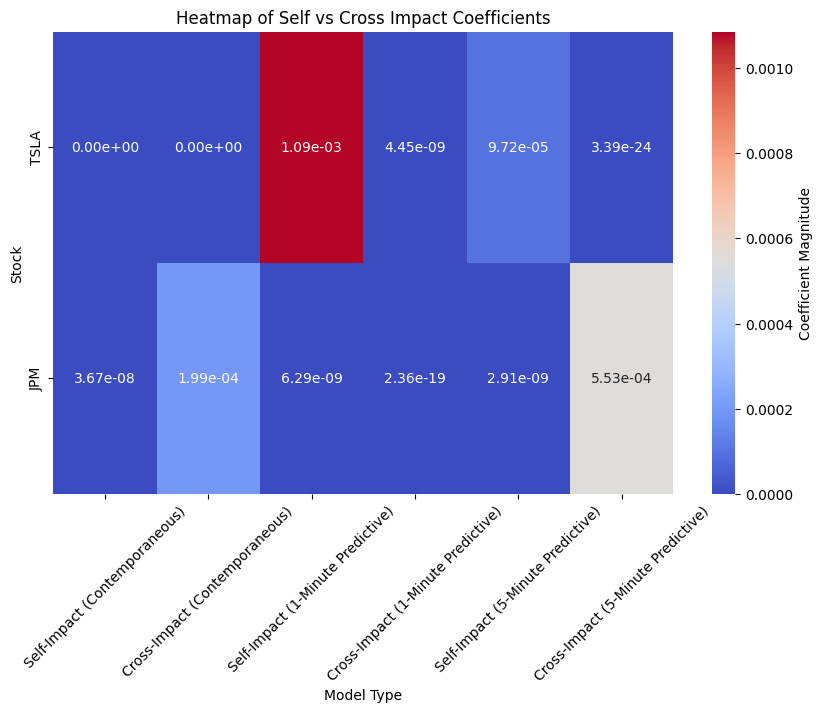

In [23]:
# Data for heatmap
heatmap_data = {
    "Self-Impact (Contemporaneous)": [0.000000, 3.667146e-08],
    "Cross-Impact (Contemporaneous)": [0.000000, 1.985757e-04],
    "Self-Impact (1-Minute Predictive)": [1.085384e-03, 6.289904e-09],
    "Cross-Impact (1-Minute Predictive)": [4.449245e-09, 2.361397e-19],
    "Self-Impact (5-Minute Predictive)": [9.724959e-05, 2.913296e-09],
    "Cross-Impact (5-Minute Predictive)": [3.389782e-24, 5.531513e-04]
}

# Convert to DataFrame
heatmap_df = pd.DataFrame(heatmap_data, index=["TSLA", "JPM"])

# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_df, annot=True, fmt=".2e", cmap="coolwarm", cbar_kws={'label': 'Coefficient Magnitude'})
plt.title("Heatmap of Self vs Cross Impact Coefficients")
plt.ylabel("Stock")
plt.xlabel("Model Type")
plt.xticks(rotation=45)
plt.show()


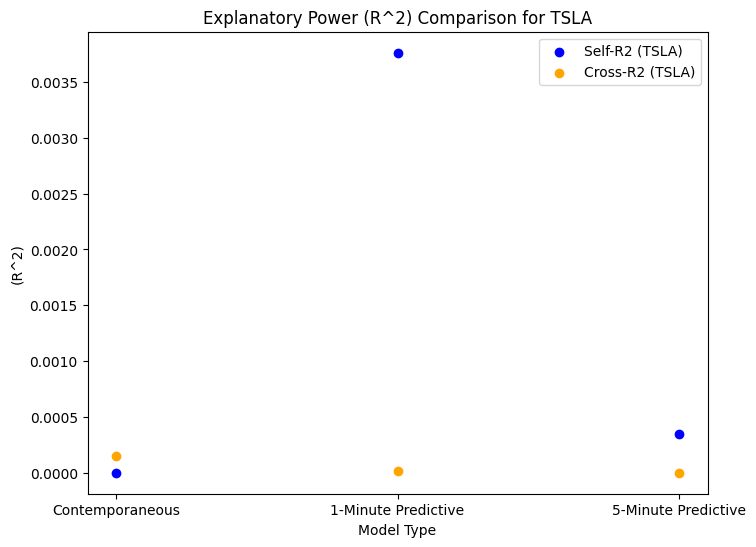

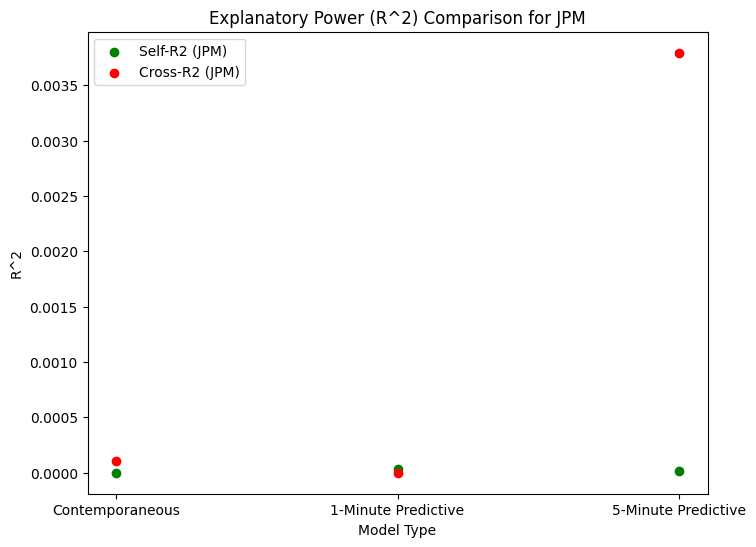

In [24]:
# Data for scatter plot
scatter_data = {
    "Model": ["Contemporaneous", "1-Minute Predictive", "5-Minute Predictive"],
    "Self-R2 (TSLA)": [0.0, 0.003763, 0.000351],
    "Cross-R2 (TSLA)": [0.000151, 0.000012,  0.000000],
    "Self-R2 (JPM)": [0.000000, 0.000037, 0.000018],
    "Cross-R2 (JPM)": [0.000105, 0.00000, 0.003793]
}

# Convert to DataFrame
scatter_df = pd.DataFrame(scatter_data)

# Plot R^2 comparison for AAPL
plt.figure(figsize=(8, 6))
plt.scatter(scatter_df["Model"], scatter_df["Self-R2 (TSLA)"], label="Self-R2 (TSLA)", color="blue")
plt.scatter(scatter_df["Model"], scatter_df["Cross-R2 (TSLA)"], label="Cross-R2 (TSLA)", color="orange")
plt.title("Explanatory Power (R^2) Comparison for TSLA")
plt.ylabel("(R^2)")
plt.xlabel("Model Type")
plt.legend()
plt.show()

# Plot R^2 comparison for AMGN
plt.figure(figsize=(8, 6))
plt.scatter(scatter_df["Model"], scatter_df["Self-R2 (JPM)"], label="Self-R2 (JPM)", color="green")
plt.scatter(scatter_df["Model"], scatter_df["Cross-R2 (JPM)"], label="Cross-R2 (JPM)", color="red")
plt.title("Explanatory Power (R^2) Comparison for JPM")
plt.ylabel("R^2")
plt.xlabel("Model Type")
plt.legend()
plt.show()
